Author: Vijul Shah<br/>
Date: 22.10.2022<br/>
Contact E-mail: shahv@rhrk.uni-kl.de<br/>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import copy
import torch
from torch import nn, optim
from torch.autograd import Variable

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

import requests
from PIL import Image
from io import BytesIO

import opacus
from opacus.validators import ModuleValidator

In [2]:
T = transforms.Compose([
    transforms.ToTensor()
])
# transforms.ToTensor => 
# Converts the image into numbers, that are understandable by the system. 
# It separates the image into three color channels (separate images): red, green & blue.
# Then it converts the pixels of each image to the brightness of their color between 0 and 255.
# These values are then scaled down to a range between 0 and 1
# The image is now a torch tensor (a multi-dimensional matrix containing elements of a single data type).

In [3]:
# Set the batch size to 64
numb_batch = 64

## Getting the Data

In [4]:
# Downloading datasets
train_data = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train=True, transform=T)
test_data = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train=False, transform=T)

In [5]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=numb_batch, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=numb_batch, shuffle=True)

## Knowing The Dataset Better

In this phase, we will be doing some exploratory data analysis on our images and tensors

In [49]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


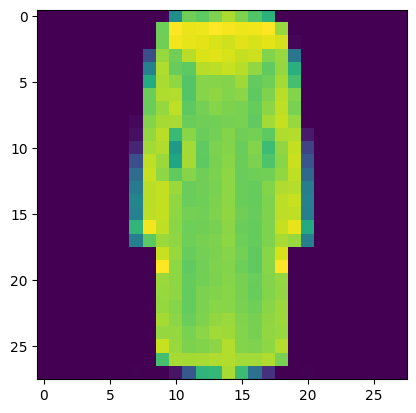

In [7]:
plt.imshow(images[2].numpy().squeeze())

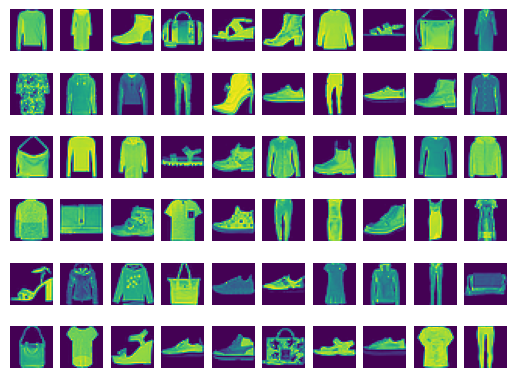

In [8]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze())

## Defining label names to Map with Images

Making a method that return the name of class for the label number. ex. if the label is 5, we return Sandal.

In [9]:
labels.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [10]:
def output_label(label):
    output_mapping = {
        0: "T-shirt/Top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat", 
        5: "Sandal", 
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle Boot"
    }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

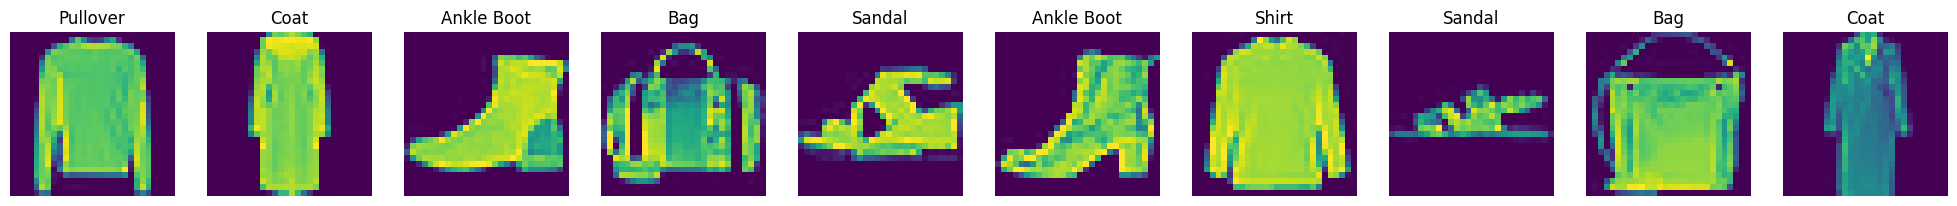

In [11]:
figure = plt.figure(figsize=(25, 25))
num_of_images = 10
for index in range(1, num_of_images + 1):
    plt.subplot(1, 10, index)
    plt.axis('off')
    plt.title(output_label(labels[index]))
    plt.imshow(images[index].numpy().squeeze())

## Pre-processing the data: normalize, standardize & augmentation

In [12]:
print('Min Pixel Value: {} \nMax Pixel Value: {}'.format(train_data.data.min(), train_data.data.max()))
print('Mean Pixel Value {} \nPixel Values Std: {}'.format(train_data.data.float().mean(), train_data.data.float().std()))
print('Scaled Mean Pixel Value {} \nScaled Pixel Values Std: {}'.format(train_data.data.float().mean() / 255, train_data.data.float().std() / 255))

Min Pixel Value: 0 
Max Pixel Value: 255
Mean Pixel Value 72.94035339355469 
Pixel Values Std: 90.02118682861328
Scaled Mean Pixel Value 0.28604060411453247 
Scaled Pixel Values Std: 0.35302427411079407


In [13]:
# FashionMNIST_MEAN = train_data.data.float().mean() / 255 
# FashionMNIST_STD = train_data.data.float().std() / 255
# transforms.Normalize((FashionMNIST_MEAN,), (FashionMNIST_STD,))

## Creating the Model

In [14]:
# Creating LeNet architecture:
# conv_out = [(W - K + 2P)/S] + 1
# conv1 = (28 - 5 + 2*2)/1 + 1 = 28 ===> 28 * 28 * 6 = 4704 params
# avg pool1 = (28-2)/2 + 1 = 14 ===> 14 * 14 * 6 = 1176
# conv2 = (14 - 5 + 2*0)/1 + 1 = 10 ===> 10 * 10 * 16 = 1600 params
# avg pool2 = (10 - 2)/2 + 1 = 5 ===> 5 * 5 * 16 = 400 params
def create_model():
    model = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2, stride=1),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding=0, stride=1),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(400, 120),
        nn.Tanh(),
        nn.Linear(120, 84),
        nn.Tanh(),
        nn.Linear(84, 10)
    )
    return model

## Validating the Model

In [15]:
def validate(model, data):
    total = 0
    correct = 0
    for i, (images, labels) in enumerate(data):
        x = model(images)
        value, pred = torch.max(x, 1) # 64 images - each will correspond to one predicted value from the max probability of 10 neurons
        total = total + x.size(0)
        correct = correct + torch.sum(pred.data == labels)
    return correct*100./total

## Training Function

In [16]:
def train(num_epoch=3, lr=0.001, use_diff_privacy=False, target_epsilon=1, max_grad_norm=10, target_delta=1e-5, trainloader=trainloader):
    accuracies = []
    cnn_model = create_model()
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn_model.parameters(), lr)
    if(use_diff_privacy):
        privacy_engine = opacus.PrivacyEngine()
        cnn_model, optimizer, trainloader = privacy_engine.make_private_with_epsilon(
            module=cnn_model,
            optimizer=optimizer,
            data_loader=trainloader,
            target_epsilon=target_epsilon,
            target_delta=target_delta,
            max_grad_norm=max_grad_norm,
            epochs=num_epoch
        )
    max_accuracy = 0.
    for epoch in range(num_epoch):
        for i, (images, labels) in enumerate(trainloader):
            optimizer.zero_grad() # initialize zero gradients to neurons for each batch of images
            prediction = cnn_model(images) # get (probabilities) predicted values (ouput-linear = 10) for each image (total = 64) from forward propogation
            loss = loss_function(prediction, labels) # calculate loss (CrossEntropyLoss) from the predicted values
            loss.backward() # do backward propogation to calculate the gradients of each neuron
            optimizer.step() # optimize the model by taking a step acc to lr
        if(use_diff_privacy):
            epsilon, best_alpha = privacy_engine.accountant.get_privacy_spent(
                delta=1/(10*len(images))
            )
            print("Epoch: ", epoch+1, "Epsilon: ",epsilon, "Best_Alpha: ",best_alpha)
        else:
            # validate the model after each epoch with optimized steps taken
            accuracy = float(validate(cnn_model, testloader))
            accuracies.append(accuracy)
            if (accuracy > max_accuracy):
                best_model = copy.deepcopy(cnn_model)
                max_accuracy = accuracy
                print("Saving best model with accuracy: ",accuracy)
            print("Epoch: ", epoch+1, " Accuracy: ", accuracy)
    if(use_diff_privacy):
        return cnn_model
    else:
        plt.plot(accuracies)
        return best_model

## Training the Model

Saving best model with accuracy:  82.93000030517578
Epoch:  1  Accuracy:  82.93000030517578
Saving best model with accuracy:  85.7300033569336
Epoch:  2  Accuracy:  85.7300033569336
Epoch:  3  Accuracy:  85.6500015258789
Saving best model with accuracy:  87.08000183105469
Epoch:  4  Accuracy:  87.08000183105469
Saving best model with accuracy:  87.80000305175781
Epoch:  5  Accuracy:  87.80000305175781


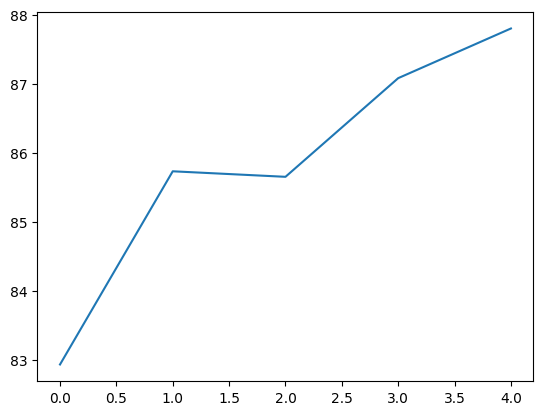

In [17]:
trained_net_1 = train(num_epoch=5)

## Saving the model

In [18]:
torch.save(trained_net_1, "FashionMNIST_Prediction_Model")

In [19]:
digits_model = torch.load("FashionMNIST_Prediction_Model")
digits_model.eval()

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): Tanh()
  (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Tanh()
  (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): Tanh()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): Tanh()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

## Creating the Function to test validation data

In [20]:
def predict_val_data(model, data):
    y_pred = []
    y_true = []
    for i, (images, labels) in enumerate(data):
        x = model(images)
        value, pred = torch.max(x, 1)
        # print("value = ",value.shape)
        # print("pred = ",pred.shape)
        # print("labels = ",list(labels.numpy()))
        y_pred.extend(list(pred.data.numpy()))
        y_true.extend(list(labels.numpy()))
    return np.array(y_pred), np.array(y_true)

In [21]:
y_pred, y_true = predict_val_data(digits_model, testloader)

## Getting any dress's image from the web and predicting it

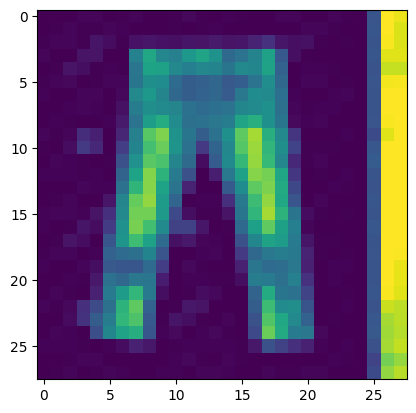

In [22]:
path = "https://thumbs.dreamstime.com/z/detail-nice-blue-jeans-black-background-87783243.jpg"
r = requests.get(path)
with BytesIO(r.content) as f:
    img = Image.open(f).convert(mode="L")
    img = img.resize((28, 28))
x = (np.expand_dims(np.array(img), -1))/255.

plt.imshow(x.squeeze(-1))

In [23]:
import torch.nn.functional as F

def predict_real_img(path, model):
    r = requests.get(path)
    with BytesIO(r.content) as f:
        img = Image.open(f).convert(mode="L")
        img = img.resize((28, 28))
        # x = (255 - np.expand_dims(np.array(img), -1))/255.
        x = (np.expand_dims(np.array(img), -1))/255.
    with torch.no_grad():
        pred = model(torch.unsqueeze(T(x), axis=0).float())
        return F.softmax(pred, dim=-1).numpy()

In [24]:
pred = predict_real_img(path, digits_model)
pred_idx = np.argmax(pred)
print(f"Predicted: {pred_idx} [{output_label(pred_idx)}], Prob: {pred[0][pred_idx]*100} %")

Predicted: 8 [Bag], Prob: 26.923024654388428 %


## Training Models with Differential Privacy

In [25]:
trained_net_diff_privacy_1 = train(num_epoch=5, use_diff_privacy=True, target_epsilon=1000)

c:\Users\VIJUL\AppData\Local\Programs\Python\Python310\lib\site-packages\opacus\privacy_engine.py:141: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
c:\Users\VIJUL\AppData\Local\Programs\Python\Python310\lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\VIJUL\AppData\Local\Programs\Python\Python310\lib\site-packages\opacus\accountants\analysis\rdp.py:332: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
c:\Users\VIJUL\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\module.py:1053: UserWarning: Using a non-f

Epoch:  1 Epsilon:  37.36680249698571 Best Alpha:  1.3
Epoch:  2 Epsilon:  47.81276684335971 Best Alpha:  1.2
Epoch:  3 Epsilon:  57.205359979161756 Best Alpha:  1.2
Epoch:  4 Epsilon:  66.08996057766906 Best Alpha:  1.2
Epoch:  5 Epsilon:  75.04443404129088 Best Alpha:  1.2


In [26]:
accuracy_diff_privacy_1 = float(validate(trained_net_diff_privacy_1, testloader))
torch.save(accuracy_diff_privacy_1, "FashionMNIST_Prediction_Model_With_Differential_Privacy_1")
accuracy_diff_privacy_1

82.5

In [27]:
trained_net_diff_privacy_2 = train(num_epoch=5, use_diff_privacy=True, target_epsilon=10)

Epoch:  1 Epsilon:  3.8442228525623676 Best Alpha:  2.5
Epoch:  2 Epsilon:  4.82002014188107 Best Alpha:  2.4
Epoch:  3 Epsilon:  5.143803162863925 Best Alpha:  2.3
Epoch:  4 Epsilon:  5.618645709279528 Best Alpha:  2.2
Epoch:  5 Epsilon:  5.9251758012825615 Best Alpha:  2.2


In [28]:
accuracy_diff_privacy_2 = float(validate(trained_net_diff_privacy_2, testloader))
torch.save(accuracy_diff_privacy_2, "FashionMNIST_Prediction_Model_With_Differential_Privacy_2")
accuracy_diff_privacy_2

80.31999969482422

In [29]:
trained_net_diff_privacy_3 = train(num_epoch=5, use_diff_privacy=True, target_epsilon=1)

Epoch:  1 Epsilon:  0.3535420483431342 Best Alpha:  10.2
Epoch:  2 Epsilon:  0.411806744541685 Best Alpha:  10.1
Epoch:  3 Epsilon:  0.3980922160260198 Best Alpha:  10.0
Epoch:  4 Epsilon:  0.3896243499023869 Best Alpha:  10.0
Epoch:  5 Epsilon:  0.4474363306574973 Best Alpha:  9.9


In [30]:
accuracy_diff_privacy_3 = float(validate(trained_net_diff_privacy_3, testloader))
torch.save(accuracy_diff_privacy_3, "FashionMNIST_Prediction_Model_With_Differential_Privacy_3")
accuracy_diff_privacy_3

76.36000061035156

### Creating classification reports

In [78]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

In [81]:
def get_classification_report(model):
    y_true = []
    y_pred = []

    tg = [output_label(a) for a in labels.unique().tolist()]

    for i, (im, l) in enumerate(testloader):
        x = model(im)
        value, pred = torch.max(x, 1) # 64 images - each will correspond to one predicted value from the max probability of 10 neurons
        for b in l.tolist():
            y_true.append(output_label(b))
        for c in pred.data.tolist():
            y_pred.append(output_label(c))

    print("macro f1 score = ",f1_score(y_true, y_pred, average='macro'))
    print("micro f1 score = ",f1_score(y_true, y_pred, average='micro'))
    print("weighted f1 score = ",f1_score(y_true, y_pred, average='weighted'))
    
    return classification_report(y_true, y_pred, target_names=tg)

### Report of model without differential privacy:

In [82]:
print(get_classification_report(trained_net_1))

macro f1 score =  0.877715634160463
micro f1 score =  0.878
weighted f1 score =  0.877715634160463
              precision    recall  f1-score   support

 T-shirt/Top       0.96      0.95      0.96      1000
     Trouser       0.98      0.97      0.97      1000
    Pullover       0.77      0.82      0.79      1000
       Dress       0.88      0.90      0.89      1000
        Coat       0.79      0.78      0.79      1000
      Sandal       0.98      0.94      0.96      1000
       Shirt       0.70      0.65      0.67      1000
     Sneaker       0.91      0.97      0.94      1000
         Bag       0.82      0.83      0.83      1000
  Ankle Boot       0.98      0.97      0.97      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



### Report of model 1 with differential privacy, epsilon=1000:

In [83]:
print(get_classification_report(trained_net_diff_privacy_1))

c:\Users\VIJUL\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


macro f1 score =  0.8227233443502211
micro f1 score =  0.825
weighted f1 score =  0.8227233443502211
              precision    recall  f1-score   support

 T-shirt/Top       0.93      0.95      0.94      1000
     Trouser       0.93      0.94      0.94      1000
    Pullover       0.73      0.70      0.71      1000
       Dress       0.81      0.83      0.82      1000
        Coat       0.65      0.75      0.70      1000
      Sandal       0.96      0.93      0.94      1000
       Shirt       0.60      0.47      0.53      1000
     Sneaker       0.91      0.93      0.92      1000
         Bag       0.76      0.81      0.78      1000
  Ankle Boot       0.94      0.94      0.94      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



### Report of model 2 with differential privacy, epsilon=10:

In [84]:
print(get_classification_report(trained_net_diff_privacy_2))

c:\Users\VIJUL\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


macro f1 score =  0.8003376922079349
micro f1 score =  0.8032
weighted f1 score =  0.800337692207935
              precision    recall  f1-score   support

 T-shirt/Top       0.90      0.94      0.92      1000
     Trouser       0.93      0.92      0.92      1000
    Pullover       0.65      0.78      0.71      1000
       Dress       0.78      0.83      0.80      1000
        Coat       0.68      0.62      0.65      1000
      Sandal       0.95      0.91      0.93      1000
       Shirt       0.51      0.41      0.46      1000
     Sneaker       0.90      0.89      0.90      1000
         Bag       0.75      0.79      0.77      1000
  Ankle Boot       0.96      0.93      0.95      1000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



### Report of model 3 with differential privacy, epsilon=1:

In [85]:
print(get_classification_report(trained_net_diff_privacy_3))

c:\Users\VIJUL\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


macro f1 score =  0.7614986972856683
micro f1 score =  0.7636
weighted f1 score =  0.7614986972856683
              precision    recall  f1-score   support

 T-shirt/Top       0.87      0.93      0.90      1000
     Trouser       0.91      0.92      0.92      1000
    Pullover       0.62      0.65      0.64      1000
       Dress       0.73      0.80      0.76      1000
        Coat       0.58      0.58      0.58      1000
      Sandal       0.92      0.83      0.87      1000
       Shirt       0.45      0.38      0.41      1000
     Sneaker       0.84      0.87      0.85      1000
         Bag       0.75      0.76      0.76      1000
  Ankle Boot       0.93      0.90      0.92      1000

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



## Deep Leakage from Gradients

In [ ]:
# def deep_leakage_from_gradients(model, origin_grad): 
#   dummy_data = torch.randn(origin_data.size())
#   dummy_label =  torch.randn(dummy_label.size())
#   optimizer = torch.optim.LBFGS([dummy_data, dummy_label] )

#   for iters in range(300):
#     def closure():
#       optimizer.zero_grad()
#       dummy_pred = model(dummy_data) 
#       dummy_loss = criterion(dummy_pred, dummy_label) 
#       dummy_grad = grad(dummy_loss, model.parameters(), create_graph=True)

#       grad_diff = sum(((dummy_grad - origin_grad) ** 2).sum() \
#         for dummy_g, origin_g in zip(dummy_grad, origin_grad))
      
#       grad_diff.backward()
#       return grad_diff
    
#     optimizer.step(closure)
    
#   return  dummy_data, dummy_label